In [1]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 

In [2]:
spks=np.load('/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/spks.npy')

In [4]:
print(spks.shape)

(18795, 30766)


In [13]:
beh=np.load('/media/maria/DATA1/Documents/data_for_suite2p/TX39_total/cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()

In [14]:
motSVD = beh['motSVD']

In [9]:
motSVD.shape

(500, 30766)

In [16]:
one_fr=spks[:200*90,300]

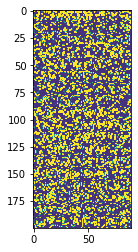

In [17]:
plt.imshow(one_fr.reshape(200,90),vmin = -0.5, vmax=3)

In [15]:
nsegs = 20
nt=motSVD.shape[1]
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, bool)
itrain[itest] = 0

In [3]:
from rastermap import mapping

model = mapping.Rastermap(bin_size=4, time_lag_window=10, ts=0.75).fit(spks)


n_PCs = 200 computed, time 48.85
landmarks computed and embedded, time 103.20
grid upsampled, time 107.15


In [4]:
print(model.X_embedding.shape)

(4698, 30766)


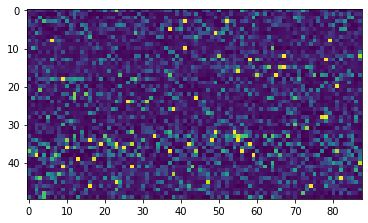

In [9]:
one_fr=model.X_embedding[:4400,900].reshape(50,88)
plt.imshow(one_fr,vmin = -0.5, vmax=3)

In [10]:
np.save('rm.npy',model.X_embedding)

In [11]:
del spks

In [ ]:
#######################

In [16]:
spks=np.expand_dims(model.X_embedding[:4400,:].T.reshape(-1,50,88),-1)

In [17]:
print(spks.shape)

(30766, 50, 88, 1)


In [18]:
spks_tr=spks[itrain,:,:,:]

In [19]:
print(spks_tr.shape)

(23066, 50, 88, 1)


In [20]:
spks_tst=spks[itest,:,:,:]
print(spks_tst.shape)

(7700, 50, 88, 1)


In [22]:
beh_tr=motSVD.T[itrain,:1]
beh_tst=motSVD.T[itest,:1]

In [23]:
beh_tr.shape


(23066, 1)

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential(
    [
        keras.Input(shape=(50,88,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="linear"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 86, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 43, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 41, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 20, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14080)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14080)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [39]:
batch_size = 128
epochs = 15

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

model.fit(spks_tr, beh_tr, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 20759 samples, validate on 2307 samples
Epoch 1/15
20759/20759 [==============================] - 35s 2ms/sample - loss: 418944.2737 - mean_squared_error: 418944.3438 - val_loss: 289006.9001 - val_mean_squared_error: 289006.8750
Epoch 2/15
20759/20759 [==============================] - 38s 2ms/sample - loss: 315425.7096 - mean_squared_error: 315425.7500 - val_loss: 277514.3193 - val_mean_squared_error: 277514.3125
Epoch 3/15
20759/20759 [==============================] - 34s 2ms/sample - loss: 300597.3439 - mean_squared_error: 300597.1875 - val_loss: 259073.0474 - val_mean_squared_error: 259073.0781
Epoch 4/15
20759/20759 [==============================] - 34s 2ms/sample - loss: 285512.8609 - mean_squared_error: 285512.8438 - val_loss: 254621.4342 - val_mean_squared_error: 254621.4688
Epoch 5/15
20759/20759 [==============================] - 35s 2ms/sample - loss: 274544.1095 - mean_squared_error: 274544.1250 - val_loss: 248000.4814 - val_mean_squared_error: 248000.4375
Epoch 

In [40]:
preds=model.predict(spks_tst)

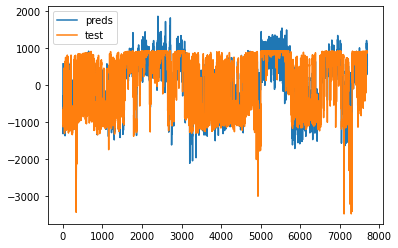

In [41]:
plt.plot(preds,label='preds')
plt.plot(beh_tst,label='test')
plt.legend()

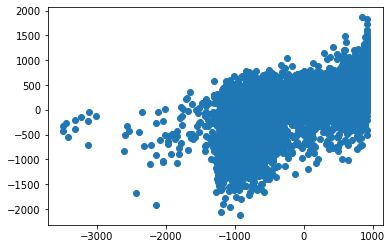

In [42]:
plt.scatter(beh_tst,preds)

In [44]:
np.corrcoef(beh_tst.T,preds.T)

array([[1.        , 0.76861241],
       [0.76861241, 1.        ]])

In [ ]:
from sklearn.metrics import explained_variance_score
explained_variance_score()